## Load required packages

In [1]:
from typing import Tuple

from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker import image_classifier

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

2022-07-09 17:32:46.182411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 17:32:46.182445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/raj/miniconda3/envs/envyoutube38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create data loader

In [2]:
data = DataLoader.from_folder('Fruits_Dataset/train')
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

2022-07-09 17:33:45.029023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-09 17:33:45.029105: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-09 17:33:45.029166: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jaimatadi): /proc/driver/nvidia/version does not exist
2022-07-09 17:33:45.051180: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Load image with size: 2909, num_label: 6, labels: Tomato_3, Tomato_4, Tomato_Cherry_Red, Tomato_Maroon, Tomato_Yellow, Walnut.


## View some samples

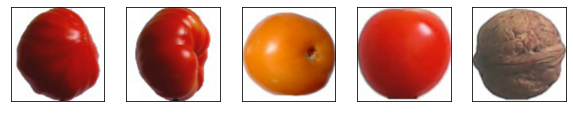

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(5)):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()], color='white')
plt.show()

## Train a model

In [6]:
model = image_classifier.create(
    train_data,
    model_spec='efficientnet_lite0',
    epochs=5,
    validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 3,420,710
Trainable params: 7,686
Non-trainable params: 3,413,024
_________________________________________________________________
None
INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


Epoch 1/5
72/72 [==============================] - 129s 2s/step - loss: 0.8270 - accuracy: 0.8433 - val_loss: 0.5064 - val_accuracy: 1.0000
Epoch 2/5
72/72 [==============================] - 119s 2s/step - loss: 0.5736 - accuracy: 0.9653 - val_loss: 0.4768 - val_accuracy: 1.0000
Epoch 3/5
72/72 [==============================] - 114s 2s/step - loss: 0.5540 - accuracy: 0.9674 - val_loss: 0.4674 - val_accuracy: 1.0000
Epoch 4/5
72/72 [==============================] - 111s 2s/step - loss: 0.5346 - accuracy: 0.9783 - val_loss: 0.4595 - val_accuracy: 1.0000
Epoch 5/5
72/72 [==============================] - 127s 2s/step - loss: 0.5294 - accuracy: 0.9787 - val_loss: 0.4587 - val_accuracy: 1.0000


## Test the model

In [7]:
loss, accuracy = model.evaluate(test_data)
predicts = model.predict_top_k(test_data, k=2)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


10/10 [==============================] - 17s 1s/step - loss: 0.4596 - accuracy: 1.0000
INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


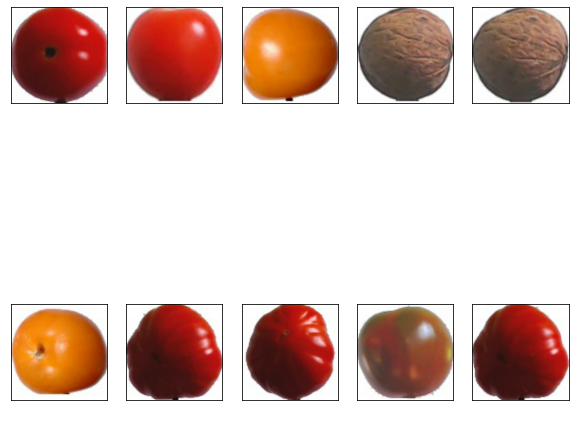

In [8]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'white'
  else:
    return 'red'

plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(10)):
  ax = plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel(predict_label)
plt.show()

## Export the model

In [ ]:
model.export(
    export_dir='.',
    tflite_filename='fruit_classifier.tflite'
)

## Predict on a single image

In [ ]:
MODEL_PATH = 'fruit_classifier.tflite'

def get_interpreter(model_path: str) -> Tuple:
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    return interpreter, input_details, output_details

def predict(image_path: str) -> int:
    interpreter, input_details, output_details = get_interpreter(MODEL_PATH)
    input_shape = input_details[0]['shape']
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, (input_shape[2], input_shape[2]))
    img = tf.expand_dims(img, axis=0)
    resized_img = tf.cast(img, dtype=tf.uint8)
    
    interpreter.set_tensor(input_details[0]['index'], resized_img)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    results = np.squeeze(output_data)
    return np.argmax(results, axis=0)

In [ ]:
predict('Fruits_Dataset/train/Walnut/0_100_jpg.rf.995d1fecae1d23d8872fec8267b7ba38.jpg')